# Set up

## (You can run all)

## Install and Clone Repo

In [ ]:
%cd /content

/content


In [ ]:
!pip install sentence_transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 2.6 MB/s eta 0:00:00


In [ ]:
# !pip install faiss-gpu
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 11.9 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/nhatkhangcs/Nomnom-model.git

Cloning into 'Nomnom-model'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 80 (delta 27), reused 66 (delta 19), pack-reused 0
Receiving objects: 100% (80/80), 223.46 KiB | 363.00 KiB/s, done.
Resolving deltas: 100% (27/27), done.


In [ ]:
# Download csv
!gdown 1KzcPWNRud2nlpZ41TMRew-gsLJM92sRF -O Nomnom-model/scripts/data/data.csv
!gdown 1i3eT_VF6yA_G4GvlAsehwSeIQmzXzn40 -O Nomnom-model/scripts/data/RAW_recipes.csv
!gdown 1eIz2a44a173XzYy2q098V0htpJ8rKB1w -O Nomnom-model/scripts/data/RAW_interactions.csv

Downloading...
From (original): https://drive.google.com/uc?id=1KzcPWNRud2nlpZ41TMRew-gsLJM92sRF
From (redirected): https://drive.google.com/uc?id=1KzcPWNRud2nlpZ41TMRew-gsLJM92sRF&confirm=t&uuid=ed4a10fb-18dc-4c98-be1b-e693dffebec9
To: /content/Nomnom-model/scripts/data/data.csv
100% 190M/190M [00:02<00:00, 92.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1i3eT_VF6yA_G4GvlAsehwSeIQmzXzn40
From (redirected): https://drive.google.com/uc?id=1i3eT_VF6yA_G4GvlAsehwSeIQmzXzn40&confirm=t&uuid=44eec5c0-f719-4bee-b553-aa6c531e4474
To: /content/Nomnom-model/scripts/data/RAW_recipes.csv
100% 295M/295M [00:02<00:00, 110MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1eIz2a44a173XzYy2q098V0htpJ8rKB1w
From (redirected): https://drive.google.com/uc?id=1eIz2a44a173XzYy2q098V0htpJ8rKB1w&confirm=t&uuid=5d9d0424-08fd-442b-be0a-a5f248cd9236
To: /content/Nomnom-model/scripts/data/RAW_interactions.csv
100% 349M/349M [00:02<00:00, 124MB/s]


In [ ]:
# Download embedded vector file
!gdown 1-7p4bHR2IAWAaZHbaRS-IUYWb1TMsvWS -O Nomnom-model/scripts/data/embedded_names.pkl
!gdown 1-6Rvib4upv9VHEl1nwB2-D1SczbTieD2 -O Nomnom-model/scripts/data/embedded_ingredients.pkl
!gdown 1yZQi3gWc90xGwXDvwvuTTMGbzzzkl1Gc -O Nomnom-model/scripts/data/embedded_tags.pkl

Downloading...
From (original): https://drive.google.com/uc?id=1-7p4bHR2IAWAaZHbaRS-IUYWb1TMsvWS
From (redirected): https://drive.google.com/uc?id=1-7p4bHR2IAWAaZHbaRS-IUYWb1TMsvWS&confirm=t&uuid=9dc5d58f-b98d-434b-a46e-12c0639db905
To: /content/Nomnom-model/scripts/data/embedded_names.pkl
100% 356M/356M [00:04<00:00, 81.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-6Rvib4upv9VHEl1nwB2-D1SczbTieD2
From (redirected): https://drive.google.com/uc?id=1-6Rvib4upv9VHEl1nwB2-D1SczbTieD2&confirm=t&uuid=1c13582d-9785-49ae-af32-ca9ee371ec64
To: /content/Nomnom-model/scripts/data/embedded_ingredients.pkl
100% 356M/356M [00:03<00:00, 105MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1yZQi3gWc90xGwXDvwvuTTMGbzzzkl1Gc
From (redirected): https://drive.google.com/uc?id=1yZQi3gWc90xGwXDvwvuTTMGbzzzkl1Gc&confirm=t&uuid=339e21b6-ddea-4c56-959b-1eae04c976f4
To: /content/Nomnom-model/scripts/data/embedded_tags.pkl
100% 356M/356M [00:02<00:00, 126MB/s]


In [ ]:
%cd Nomnom-model/scripts

/content/Nomnom-model/scripts


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import pickle
import os
import faiss
import ast
import time

## Create model class

In [ ]:
class SearchModel():
    def __init__(self, nutritions_scaler=None):
        self.data = {}
        self.weights = [1.0, 1.0, 1.0, 1.0, 1.0]
        # self.embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
        self.embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        self.index_for_name = None # Index is the model by faiss
        self.index_for_tags = None
        self.index_for_ingredients = None
        self.index_for_nutrition = None
        self.scaler = nutritions_scaler
        self.NUTRITIONS = ['calories', 'fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carbohydrates']

    def embed(self, sentences):
        '''
            sentences: list of strings
            return: list of embeddings
        '''
        return self.embedding_model.encode(sentences)

    def fit_name(self, embeddings):
        print('[+] Fitiing names...')
        self.index_for_name = faiss.IndexFlatIP(embeddings.shape[1])  # IndexFlatIP for inner product (cosine similarity)
        self.index_for_name.add(embeddings)

    def fit_tag(self, embeddings):
        print('[+] Fitiing tags...')
        self.index_for_tags = faiss.IndexFlatIP(embeddings.shape[1])  # IndexFlatIP for inner product (cosine similarity)
        self.index_for_tags.add(embeddings)

    def fit_ingredients(self, embeddings):
        print('[+] Fitiing ingredients...')
        self.index_for_ingredients = faiss.IndexFlatIP(embeddings.shape[1])  # IndexFlatIP for inner product (cosine similarity)
        self.index_for_ingredients.add(embeddings)

    def fit_nutrition(self, nutrition):
        print('[+] Fitiing nutrition...')
        nutrition = np.ascontiguousarray(nutrition, dtype=np.float32)
        self.index_for_nutrition = faiss.IndexFlatL2(7)  # IndexFlatL1 for L1 distance (Manhattan)
        self.index_for_nutrition.add(nutrition)

    def fit(self, embedded_names, embedded_tags, embedded_ingredients, nutritions_scaled):
        self.fit_name(embedded_names)
        self.fit_tag(embedded_tags)
        self.fit_ingredients(embedded_ingredients)
        self.fit_nutrition(nutritions_scaled)
        print('[++++] DONE')

    def load(self, data):
        '''
            data: dataframe
        '''
        print('[+] Loading data into model...')
        self.data = data
        print('[+] DONE')

    def search(self, name: str=None, tags: str=None, ingredients: str=None, nutrition: list[float]=None, k=1000):
        '''
            return: list of similar
        '''
        print('[+] Retrieving similar foods...')
        final_res = {}
        if name:
            embedded_name = self.embedding_model.encode(name)
            name_scores, name_indices = self.index_for_name.search(embedded_name.reshape(1, -1), k=k)
            for i, idx in enumerate(name_indices[0]):
                if idx not in final_res:
                    final_res[idx] = {}
                final_res[idx]['name'] = name_scores[0][i] * self.weights[0]

        if tags:
            embedded_tags = self.embedding_model.encode(tags)
            tags_scores, tags_indices = self.index_for_tags.search(embedded_tags.reshape(1, -1), k=k)
            for i, idx in enumerate(tags_indices[0]):
                if idx not in final_res:
                    final_res[idx] = {}
                final_res[idx]['tags'] = tags_scores[0][i] * self.weights[1]

        if ingredients:
            embedded_ingredients = self.embedding_model.encode(ingredients)
            ingredients_scores, ingredients_indices = self.index_for_ingredients.search(embedded_ingredients.reshape(1, -1), k=k)
            for i, idx in enumerate(ingredients_indices[0]):
                if idx not in final_res:
                    final_res[idx] = {}
                final_res[idx]['ingredients'] = ingredients_scores[0][i] * self.weights[2]

        if nutrition:
            scaled_nutrition = np.array(nutrition).reshape(1, -1)
            scaled_nutrition = self.scaler.transform(scaled_nutrition)
            nutrition_scores, nutrition_indices = self.index_for_nutrition.search(scaled_nutrition.reshape(1, -1), k=k)
            max_nutrition_scores = max(nutrition_scores[0])
            normalized_nutrition_scores = [1 - score/max_nutrition_scores for score in nutrition_scores[0]]
            for i, idx in enumerate(nutrition_indices[0]):
                if idx not in final_res:
                    final_res[idx] = {}
                final_res[idx]['nutrition'] = normalized_nutrition_scores[i] * self.weights[3]

        final_list = [
            (idx, sum([score for crit, score in scores.items()])) for idx, scores in final_res.items()
        ]
        print(len(final_list))

        return [(self.data.iloc[idx], score) for idx, score in sorted(final_list, key=lambda x: x[1], reverse=True)]


In [ ]:
class BetterSearchModel(SearchModel):
    def search(self, name: str=None, tags: list[str]=None, ingredients: list[str]=None, nutrition: list[float]=None, k=1000, must_have_tags=False, must_have_all_tags=False, rating_important=False):
        '''
            return: list of similar
        '''
        print('[+] Retrieving similar foods...')
        final_res = {}
        n_params = 0
        if name:
            n_params += 1
            embedded_name = self.embedding_model.encode(name)
            name_scores, name_indices = self.index_for_name.search(embedded_name.reshape(1, -1), k=k)
            for i, idx in enumerate(name_indices[0]):
                if idx not in final_res:
                    final_res[idx] = {}
                final_res[idx]['name'] = name_scores[0][i] * self.weights[0]

        if tags:
            n_params += 1
            concat_tags = ' '.join(tags)

            embedded_tags = self.embedding_model.encode(concat_tags)
            tags_scores, tags_indices = self.index_for_tags.search(embedded_tags.reshape(1, -1), k=k)
            for i, idx in enumerate(tags_indices[0]):
                if idx not in final_res:
                    final_res[idx] = {}
                final_res[idx]['tags'] = tags_scores[0][i] * self.weights[1]

        if ingredients:
            n_params += 1
            concat_ingredients = ', '.join(ingredients)

            embedded_ingredients = self.embedding_model.encode(concat_ingredients)
            ingredients_scores, ingredients_indices = self.index_for_ingredients.search(embedded_ingredients.reshape(1, -1), k=k)
            for i, idx in enumerate(ingredients_indices[0]):
                if idx not in final_res:
                    final_res[idx] = {}
                final_res[idx]['ingredients'] = ingredients_scores[0][i] * self.weights[2]

        if nutrition:
            n_params += 1
            nutrition = np.array(nutrition).reshape(1, -1)
            scaled_nutrition = self.scaler.transform(nutrition)

            nutrition_scores, nutrition_indices = self.index_for_nutrition.search(scaled_nutrition.reshape(1, -1), k=k)
            max_nutrition_scores = max(nutrition_scores[0])
            normalized_nutrition_scores = [1 - score/max_nutrition_scores for score in nutrition_scores[0]]
            for i, idx in enumerate(nutrition_indices[0]):
                if idx not in final_res:
                    final_res[idx] = {}
                final_res[idx]['nutrition'] = normalized_nutrition_scores[i] * self.weights[3]

        if not n_params:
            print(f'No field is provided')
            return None

        food_list = [
            (idx, sum([score for field, score in scores.items()])) for idx, scores in final_res.items()
        ]
        filtered_food_list = []
        remained_food_list = food_list

        print(f'Fields: {n_params} -> {len(food_list)}')

        if tags and must_have_tags:
            df = self.data[self.data.index.isin([idx for idx, score in food_list])].copy()
            print(tags, len(df))
            if must_have_all_tags:
                df = df[df['tags'].apply(lambda food_tags: all(tag in food_tags for tag in tags))]
            else:
                df = df[df['tags'].apply(lambda food_tags: any(tag in food_tags for tag in tags))]

            filtered_food_list = [(idx, score) for idx, score in food_list if idx in df.index]
            filtered_food_list_id = [idx_score[0] for idx_score in filtered_food_list]
            print(f"Filtered tags {'(all)' if must_have_all_tags else '(any)'} -> {len(filtered_food_list)}")

            remained_food_list = [idx_score for idx_score in food_list if idx_score[0] not in filtered_food_list_id]

        votes_LOG10_MAX = 3.2076343673889616
        def calculate_bonus(columns):
            if not rating_important:
                return 0
            votes, rating = columns['votes'], columns['rating']
            votes_log10 = np.log10(votes)
            return (rating/5) * (votes_log10/votes_LOG10_MAX) * self.weights[4]

        df_filtered_food = self.data[self.data.index.isin([idx for idx, score in filtered_food_list])].copy()
        df_filtered_food.loc[:, 'score'] = [score for idx, score in filtered_food_list]
        df_filtered_food.loc[:, 'bonus'] = df_filtered_food.apply(calculate_bonus, axis=1)
        df_filtered_food.loc[:, 'total'] = df_filtered_food['score'] + df_filtered_food['bonus']
        df_filtered_food = df_filtered_food.sort_values(by='total', ascending=False)

        df_remained_food = self.data[self.data.index.isin([idx for idx, score in remained_food_list])].copy()
        df_remained_food.loc[:, 'score'] = [score for idx, score in remained_food_list]
        df_remained_food.loc[:, 'bonus'] = df_remained_food.apply(calculate_bonus, axis=1)
        df_remained_food.loc[:, 'total'] = df_remained_food['score'] + df_remained_food['bonus']
        df_remained_food = df_remained_food.sort_values(by='total', ascending=False)

        print(f"[{'+'*n_params}] DONE")
        return pd.concat([df_filtered_food, df_remained_food])

# Load data, transfer strings into python objects

In [ ]:
df = pd.read_csv('data/RAW_recipes.csv')
df.head(10)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8
5,apple a day milk shake,5289,0,1533,1999-12-06,"['15-minutes-or-less', 'time-to-make', 'course...","[160.2, 10.0, 55.0, 3.0, 9.0, 20.0, 7.0]",4,"['combine ingredients in blender', 'cover and ...",NaN,"['milk', 'vanilla ice cream', 'frozen apple ju...",4
6,aww marinated olives,25274,15,21730,2002-04-14,"['15-minutes-or-less', 'time-to-make', 'course...","[380.7, 53.0, 7.0, 24.0, 6.0, 24.0, 6.0]",4,['toast the fennel seeds and lightly crush the...,my italian mil was thoroughly impressed by my ...,"['fennel seeds', 'green olives', 'ripe olives'...",9
7,backyard style barbecued ribs,67888,120,10404,2003-07-30,"['weeknight', 'time-to-make', 'course', 'main-...","[1109.5, 83.0, 378.0, 275.0, 96.0, 86.0, 36.0]",10,['in a medium saucepan combine all the ingredi...,this recipe is posted by request and was origi...,"['pork spareribs', 'soy sauce', 'fresh garlic'...",22
8,bananas 4 ice cream pie,70971,180,102353,2003-09-10,"['weeknight', 'time-to-make', 'course', 'main-...","[4270.8, 254.0, 1306.0, 111.0, 127.0, 431.0, 2...",8,"['crumble cookies into a 9-inch pie plate , or...",NaN,"['chocolate sandwich style cookies', 'chocolat...",6
9,beat this banana bread,75452,70,15892,2003-11-04,"['weeknight', 'time-to-make', 'course', 'main-...","[2669.3, 160.0, 976.0, 107.0, 62.0, 310.0, 138.0]",12,"['preheat oven to 350 degrees', 'butter two 9x...",from ann hodgman's,"['sugar', 'unsalted butter', 'bananas', 'eggs'...",9


In [ ]:
df['name'] = df['name']
df['tags'] = df['tags'].apply(ast.literal_eval)
df['ingredients'] = df['ingredients'].apply(ast.literal_eval)
df['nutrition'] = df['nutrition'].apply(ast.literal_eval)

In [ ]:
df.shape

(231637, 12)

In [ ]:
NUTRITIONS = ['calories', 'fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carbohydrates']
# Unpack the "Nutrition" column into separate columns
df[NUTRITIONS] = pd.DataFrame(df['nutrition'].tolist(), index=df.index)
df[NUTRITIONS].head(10)

,calories,fat,sugar,sodium,protein,saturated_fat,carbohydrates
0,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,352.9,1.0,337.0,23.0,3.0,0.0,28.0
5,160.2,10.0,55.0,3.0,9.0,20.0,7.0
6,380.7,53.0,7.0,24.0,6.0,24.0,6.0
7,1109.5,83.0,378.0,275.0,96.0,86.0,36.0
8,4270.8,254.0,1306.0,111.0,127.0,431.0,220.0
9,2669.3,160.0,976.0,107.0,62.0,310.0,138.0


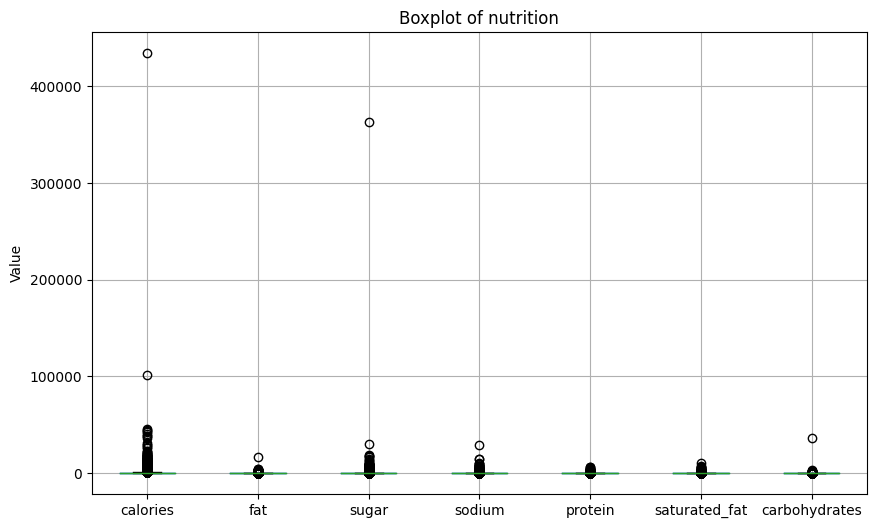

In [ ]:
import matplotlib.pyplot as plt

# Create a boxplot for the selected columns
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
df[NUTRITIONS].boxplot()

# Customize the plot
plt.title('Boxplot of nutrition')
plt.ylabel('Value')

# Show the plot
plt.show()


## Remove outliers for nutrients value scaler

In [ ]:
nutritions = df[NUTRITIONS]

In [ ]:
# Calculate Z-scores for each attribute
z_scores = (nutritions - np.mean(nutritions, axis=0)) / np.std(nutritions, axis=0)

# Define threshold for outlier detection (e.g., 3 standard deviations from the mean)
threshold = 3

# Find indices of outliers
outlier_indices = np.where(np.abs(z_scores) > threshold)

# Remove outliers
df_cleaned = df.drop(outlier_indices[0])

print("Original data shape:", df.shape)
print("Cleaned data shape:", df_cleaned.shape)

Original data shape: (231637, 19)
Cleaned data shape: (226048, 19)


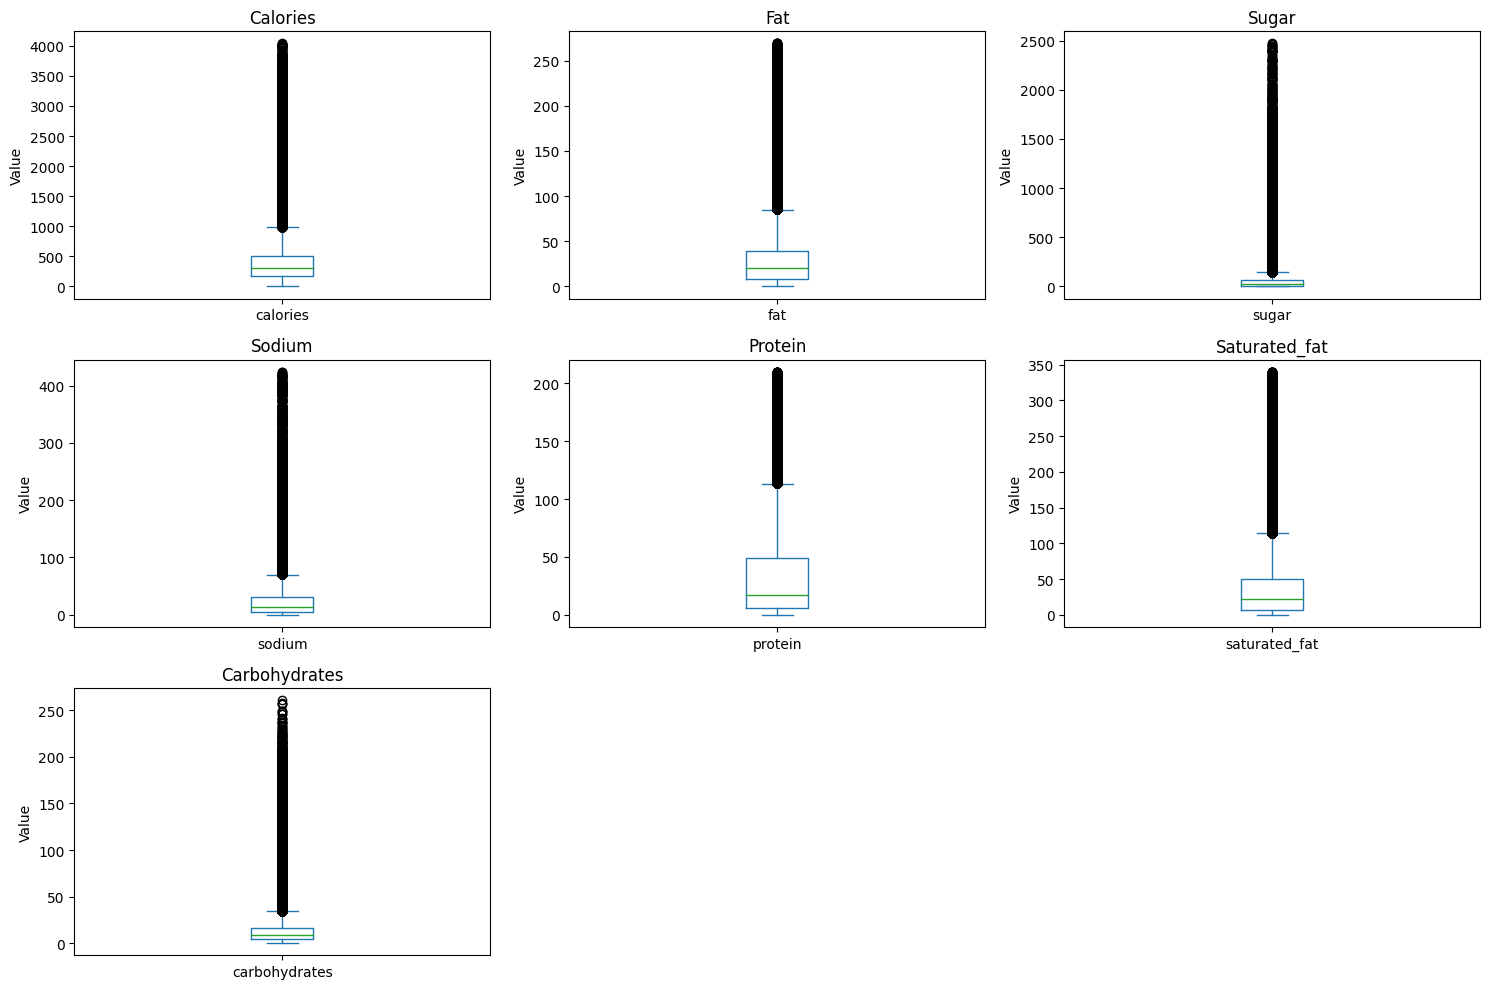

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))  # Adjust figure size as needed

for i, feature in enumerate(NUTRITIONS, 1):
    plt.subplot(3, 3, i)  # Create a subplot for each feature
    df_cleaned[feature].plot(kind='box')
    plt.title(feature.capitalize())  # Set feature name as title
    plt.ylabel('Value')

plt.tight_layout()  # Adjust layout to prevent overlapping titles
plt.show()


## Define scaler for nutrients

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_cleaned[NUTRITIONS])

StandardScaler()

# Prepare data to load to model

## Recipe info

Embed data (if not download .pkl files from drive yet)

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# # change "/content/gdrive/MyDrive/"  to "/mydrive so you can use directly /mydrive"
# !ln -s /content/gdrive/MyDrive/ /mydrive


# embedded_names = model.embedding_model.encode(df['name'])
# embedded_tags = model.embedding_model.encode(df['tags'])
# embedded_ingredients = model.embedding_model.encode(df['ingredients'])

# with open('/content/gdrive/MyDrive/[232] Nomnom WebApp/Embedding/embedded_names.pkl', 'wb') as f:
#     pickle.dump(embedded_names, f)
# with open('/content/gdrive/MyDrive/[232] Nomnom WebApp/Embedding/embedded_tags.pkl', 'wb') as f:
#     pickle.dump(embedded_tags, f)
# with open('/content/gdrive/MyDrive/[232] Nomnom WebApp/Embedding/embedded_ingredients.pkl', 'wb') as f:
#     pickle.dump(embedded_ingredients, f)

In [ ]:
# If exist embedding vectors file
EMBEDDED_NAME_PATH = 'data/embedded_names.pkl'
EMBEDDED_TAGS_PATH = 'data/embedded_tags.pkl'
EMBEDDED_INGR_PATH = 'data/embedded_ingredients.pkl'

with open(EMBEDDED_NAME_PATH, 'rb') as f:
		embedded_names = pickle.load(f)
with open(EMBEDDED_TAGS_PATH, 'rb') as f:
		embedded_tags = pickle.load(f)
with open(EMBEDDED_INGR_PATH, 'rb') as f:
		embedded_ingredients = pickle.load(f)

nutritions_scaled = scaler.transform(df[NUTRITIONS])

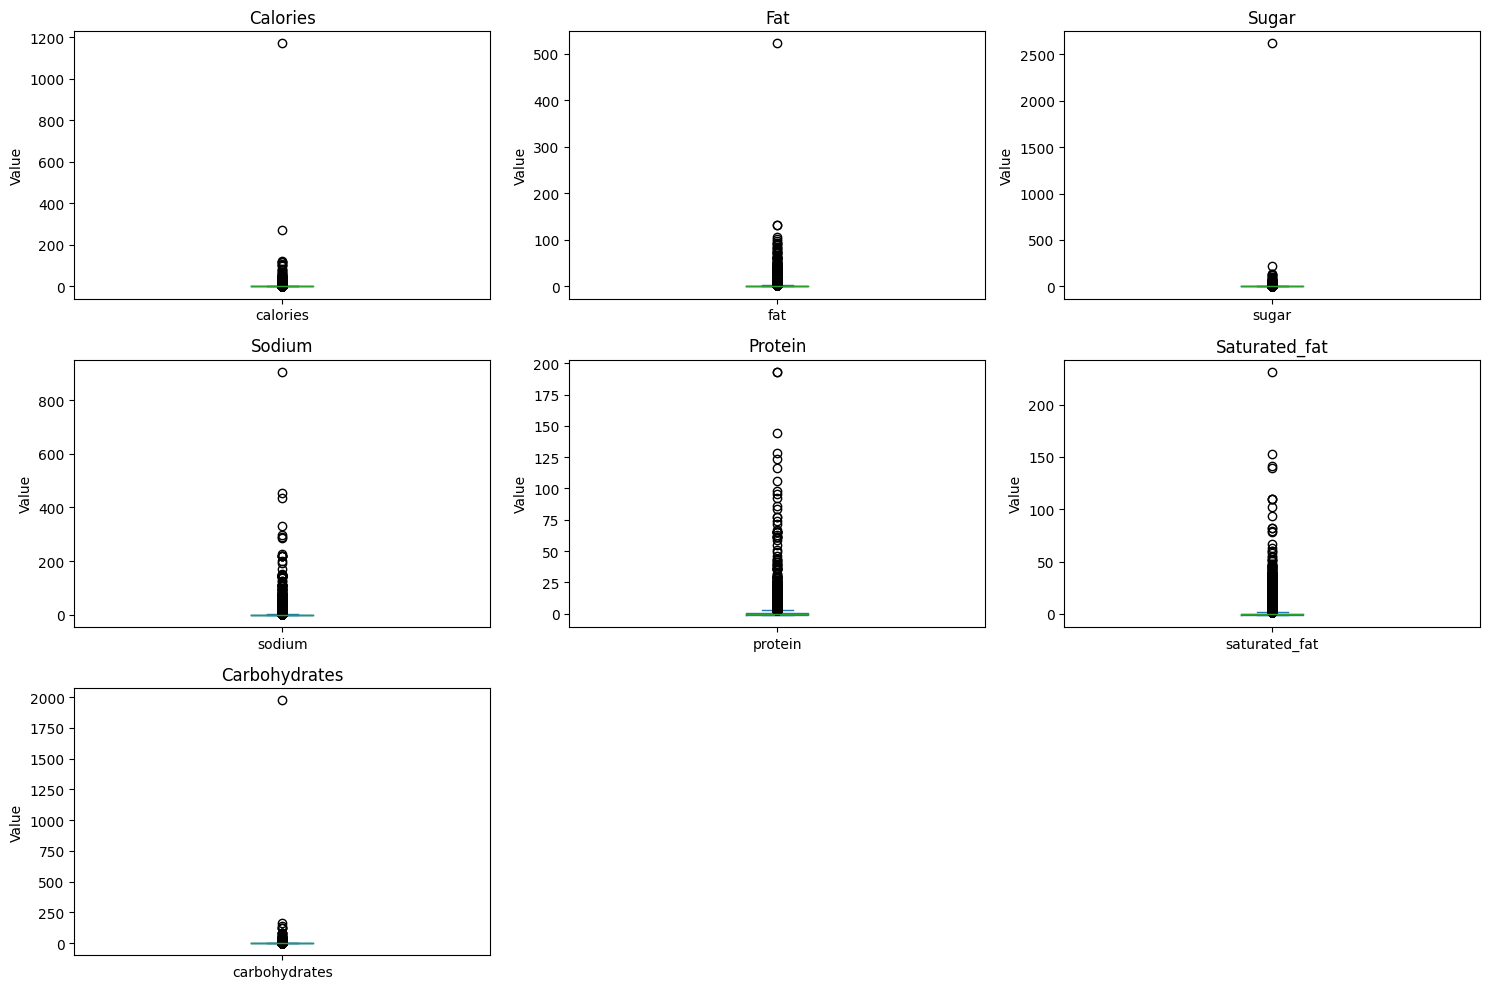

In [ ]:
# Create a new DataFrame with scaled nutrition data
df_nutritions_scaled = pd.DataFrame(nutritions_scaled, columns=NUTRITIONS)

plt.figure(figsize=(15, 10))  # Adjust figure size as needed

for i, nutrient in enumerate(NUTRITIONS, 1):
    plt.subplot(3, 3, i)  # Create a subplot for each feature
    df_nutritions_scaled[nutrient].plot(kind='box')
    plt.title(nutrient.capitalize())  # Set feature name as title
    plt.ylabel('Value')

plt.tight_layout()  # Adjust layout to prevent overlapping titles
plt.show()

## Rating info

In [ ]:
import pandas as pd
rating_df = pd.read_csv('data/RAW_interactions.csv')
rating_df

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...


In [ ]:
rating_df = rating_df.drop(['user_id','date','review'],axis=1)
rating_df.head()

,recipe_id,rating
0,40893,4
1,40893,5
2,44394,4
3,85009,5
4,85009,5


In [ ]:
len(rating_df)

1132367

In [ ]:
RATING_MEAN_ALL = rating_df['rating'].mean()
RATING_MEAN_ALL

4.411016039852804

In [ ]:
grouped_rating_df = rating_df.groupby(['recipe_id'])['rating'].agg(['mean','count'])
grouped_rating_df.reset_index(inplace=True)
grouped_rating_df

,recipe_id,mean,count
0,38,4.250000,4
1,39,3.000000,1
2,40,4.333333,9
3,41,4.500000,2
4,43,1.000000,1
...,...,...,...
231632,537459,5.000000,1
231633,537485,5.000000,1
231634,537543,0.000000,1
231635,537671,0.000000,1


In [ ]:
final_df = pd.merge(df, grouped_rating_df, left_on='id', right_on='recipe_id')
final_df.rename(columns={'count': 'votes', 'mean': 'rating'}, inplace=True)
final_df = final_df.drop(['recipe_id'], axis=1)
print(len(df), len(final_df)) # -> Every food_id has at least 1 rating

231637 231637


In [ ]:
print(final_df['votes'].describe(), final_df['rating'].describe())

count    231637.000000
mean          4.888541
std          17.532481
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        1613.000000
Name: votes, dtype: float64 count    231637.000000
mean          4.346246
std           0.990806
min           0.000000
25%           4.000000
50%           4.714286
75%           5.000000
max           5.000000
Name: rating, dtype: float64


Transform to workable range

In [ ]:
import numpy as np

# Apply log10 transformation to the 'votes' column
votes_LOG10 = np.log10(final_df['votes'])

# Calculate the min and max values of the 'rating' column
min_value = final_df['rating'].min()
max_value = final_df['rating'].max()
# Perform min-max scaling
rating_NORM = (final_df['rating'] - min_value) / (max_value - min_value)

print(votes_LOG10.describe(), rating_NORM.describe())

count    231637.000000
mean          0.381908
std           0.416348
min           0.000000
25%           0.000000
50%           0.301030
75%           0.602060
max           3.207634
Name: votes, dtype: float64 count    231637.000000
mean          0.869249
std           0.198161
min           0.000000
25%           0.800000
50%           0.942857
75%           1.000000
max           1.000000
Name: rating, dtype: float64


In [ ]:
votes_MEDIAN = final_df['votes'].median()
rating_MEDIAN = final_df['rating'].median()
votes_LOG10_MEDIAN = votes_LOG10.median()
votes_LOG10_MAX = votes_LOG10.max()
rating_NORM_MEDIAN = rating_NORM.median()
print(votes_MEDIAN, votes_LOG10_MEDIAN, votes_LOG10_MAX, rating_MEDIAN, rating_NORM_MEDIAN)

2.0 0.3010299956639812 3.2076343673889616 4.714285714285714 0.9428571428571428


In [ ]:
print(final_df['votes'].quantile(0.9), votes_LOG10.quantile(0.9), final_df['rating'].quantile(0.1), rating_NORM.quantile(0.1))

9.0 0.9542425094393249 3.0 0.6


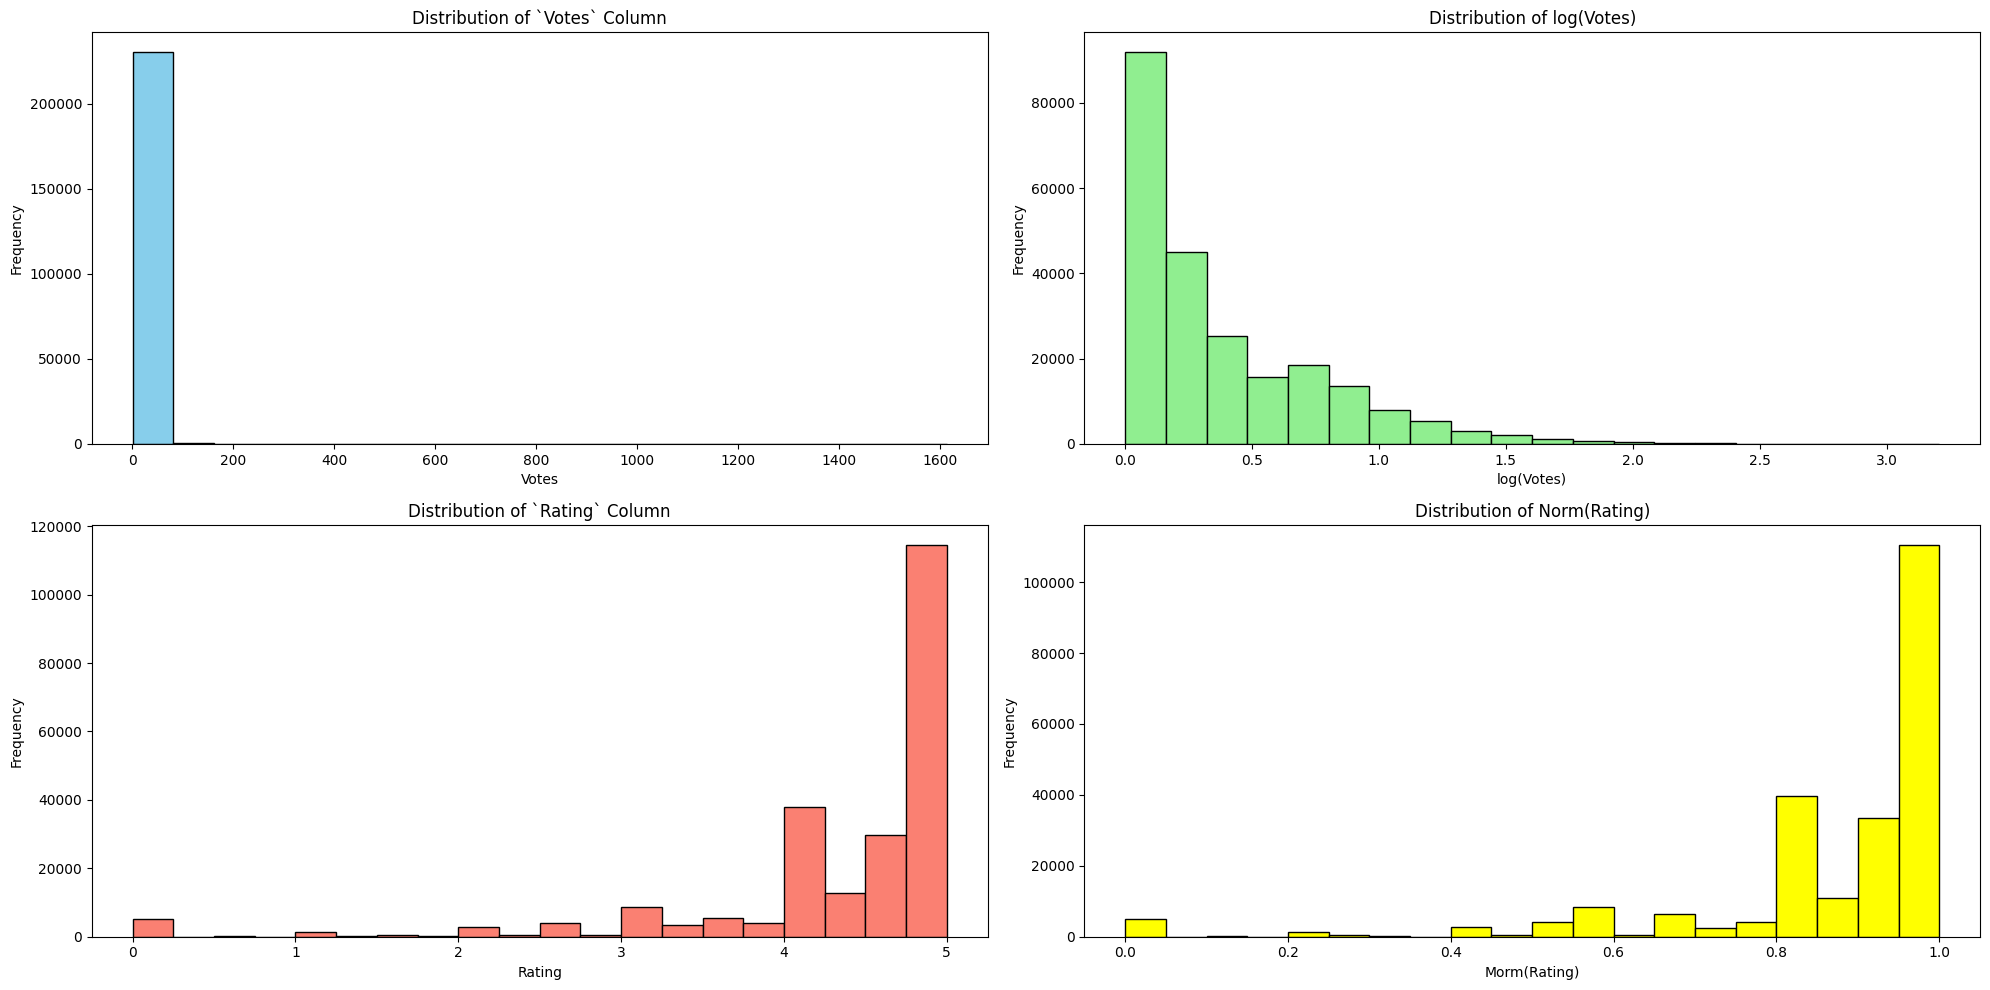

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis objects with 1 row and 3 columns
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

# Plot histogram of 'count' column
ax1.hist(final_df['votes'], bins=20, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of `Votes` Column')
ax1.set_xlabel('Votes')
ax1.set_ylabel('Frequency')

# Plot histogram of 'std' column
ax2.hist(votes_LOG10, bins=20, color='lightgreen', edgecolor='black')
ax2.set_title('Distribution of log(Votes)')
ax2.set_xlabel('log(Votes)')
ax2.set_ylabel('Frequency')

# Plot histogram of 'mean' column
ax3.hist(final_df['rating'], bins=20, color='salmon', edgecolor='black')
ax3.set_title('Distribution of `Rating` Column')
ax3.set_xlabel('Rating')
ax3.set_ylabel('Frequency')

# Plot histogram of 'mean' column
ax4.hist(rating_NORM, bins=20, color='yellow', edgecolor='black')
ax4.set_title('Distribution of Norm(Rating)')
ax4.set_xlabel('Morm(Rating)')
ax4.set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


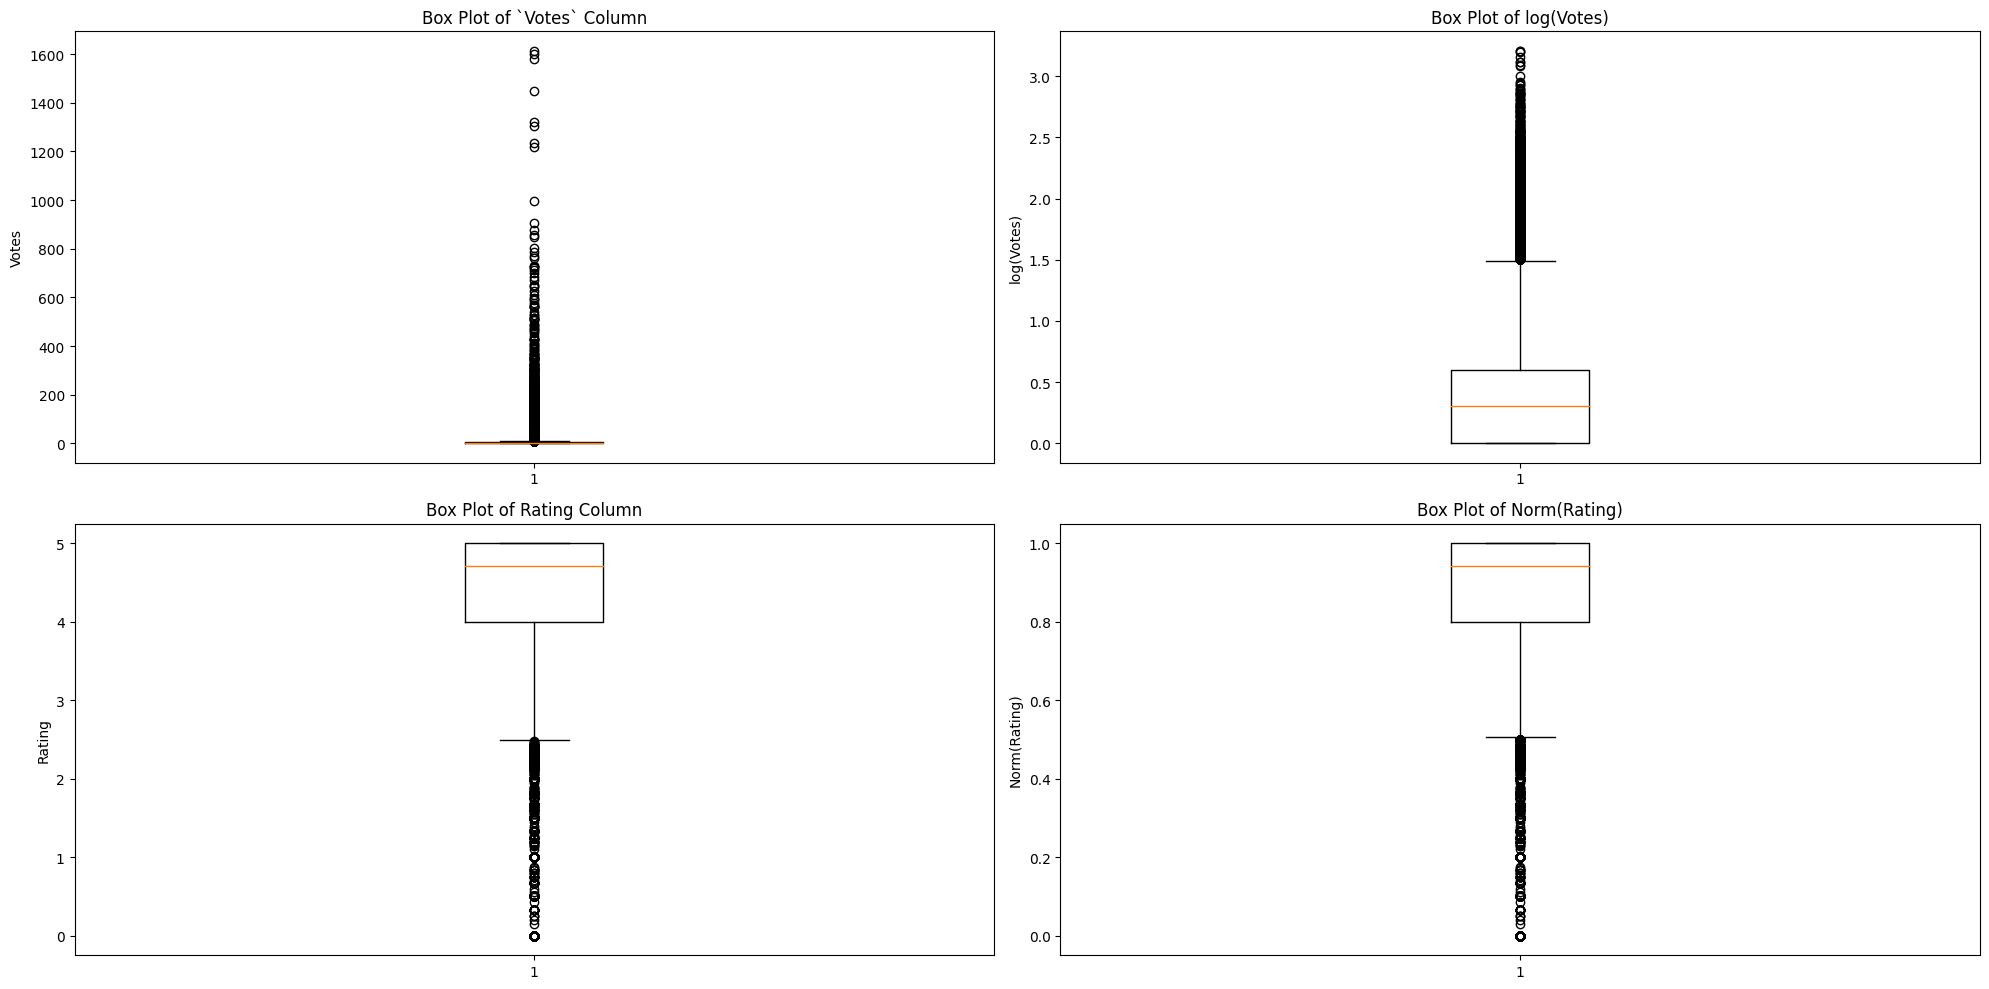

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis objects
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

# Plot box plot of 'count' column
ax1.boxplot(final_df['votes'])
ax1.set_title('Box Plot of `Votes` Column')
ax1.set_ylabel('Votes')

# Plot box plot of 'count' column
ax2.boxplot(votes_LOG10)
ax2.set_title('Box Plot of log(Votes)')
ax2.set_ylabel('log(Votes)')

# Plot box plot of 'mean' column
ax3.boxplot(final_df['rating'])
ax3.set_title('Box Plot of Rating Column')
ax3.set_ylabel('Rating')

# Plot box plot of 'mean' column
ax4.boxplot(rating_NORM)
ax4.set_title('Box Plot of Norm(Rating)')
ax4.set_ylabel('Norm(Rating)')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
final_df

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,n_ingredients,calories,fat,sugar,sodium,protein,saturated_fat,carbohydrates,rating,votes
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"[60-minutes-or-less, time-to-make, course, mai...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,...,7,51.5,0.0,13.0,0.0,2.0,0.0,4.0,5.0,3
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"[30-minutes-or-less, time-to-make, course, mai...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,6,173.4,18.0,0.0,17.0,22.0,35.0,1.0,3.5,4
2,all in the kitchen chili,112140,130,196586,2005-02-25,"[time-to-make, course, preparation, main-dish,...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,...,13,269.8,22.0,32.0,48.0,39.0,27.0,5.0,4.0,1
3,alouette potatoes,59389,45,68585,2003-04-14,"[60-minutes-or-less, time-to-make, course, mai...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...",...,11,368.1,17.0,10.0,2.0,14.0,8.0,20.0,4.5,2
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"[weeknight, time-to-make, course, main-ingredi...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,...,8,352.9,1.0,337.0,23.0,3.0,0.0,28.0,5.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231632,zydeco soup,486161,60,227978,2012-08-29,"[ham, 60-minutes-or-less, time-to-make, course...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,...,22,415.2,26.0,34.0,26.0,44.0,21.0,15.0,5.0,6
231633,zydeco spice mix,493372,5,1500678,2013-01-09,"[15-minutes-or-less, time-to-make, course, pre...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,...,13,14.8,0.0,2.0,58.0,1.0,0.0,1.0,5.0,1
231634,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"[60-minutes-or-less, time-to-make, course, mai...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style",...,8,59.2,6.0,2.0,3.0,6.0,5.0,0.0,5.0,5
231635,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"[30-minutes-or-less, time-to-make, course, pre...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...",...,10,188.0,11.0,57.0,11.0,7.0,21.0,9.0,1.0,1


# Create model

In [ ]:
bettermodel = BetterSearchModel(scaler)
bettermodel.load(final_df)
bettermodel.fit(embedded_names, embedded_tags, embedded_ingredients, nutritions_scaled)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[+] Loading data into model...
[+] DONE
[+] Fitiing names...
[+] Fitiing tags...
[+] Fitiing ingredients...
[+] Fitiing nutrition...
[++++] DONE


## Inference

In [ ]:
start_time = time.time()

bettermodel.weights = [
    1.0, # name
    0, # tags
    0.8, # ingredients
    0.2, # nutrition
    0.8  # bonus from rating and votes
]
similar_foods = bettermodel.search(
    name='pho',
    ingredients=['beef'],
    tags=['vietnamese'],
    # nutrition=[700, 80, 10, 50, 150, 30, 50], # NUTRITIONS = ['calories', 'fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carbohydrates']
    # must_have_tags=True,
    # must_have_all_tags=True,
    rating_important=True,
    k=2000
)[:20] # Take 20 most similar

end_time = time.time()

similar_foods

[+] Retrieving similar foods...
Fields: 3 -> 5866
[+++] DONE


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,sugar,sodium,protein,saturated_fat,carbohydrates,rating,votes,score,bonus,total
39847,cheesecake factory bang bang chicken and shrim...,206347,50,372178,2007-01-19,"[curries, 60-minutes-or-less, time-to-make, co...","[1211.0, 129.0, 86.0, 40.0, 43.0, 231.0, 33.0]",30,['make the curry sauce by heating the chili oi...,this is a replica of the bang bang chicken and...,...,86.0,40.0,43.0,231.0,33.0,3.769231,13,0.702881,0.209436,0.912317
290,the creamed dried beef chipped beef recipe,163238,75,168416,2006-04-06,"[time-to-make, course, main-ingredient, prepar...","[540.6, 49.0, 6.0, 78.0, 56.0, 100.0, 11.0]",7,"['melt butter in 2 quart sauce pan or larger',...",this is a long-time favorite recipe of our lan...,...,6.0,78.0,56.0,100.0,11.0,4.909091,11,0.654108,0.255006,0.909114
4114,almost tortuga rum cake,108524,100,131659,2005-01-16,"[time-to-make, course, cuisine, preparation, o...","[628.4, 51.0, 198.0, 24.0, 10.0, 62.0, 22.0]",21,"['basic cake mix: in a large mixing bowl , com...",next best to the original! on our visit to the...,...,198.0,24.0,10.0,62.0,22.0,4.478632,117,0.425535,0.462030,0.887565
82336,farro salad,379881,40,58104,2009-07-01,"[60-minutes-or-less, time-to-make, course, mai...","[49.4, 5.0, 6.0, 3.0, 3.0, 3.0, 1.0]",10,['in a pot with the hot water seasoned with sa...,this refreshingly sweet salad is a tasty culin...,...,6.0,3.0,3.0,3.0,1.0,4.750000,4,0.735083,0.142649,0.877732
4172,aloo gobi,84324,60,124813,2004-02-18,"[curries, 60-minutes-or-less, time-to-make, co...","[215.9, 11.0, 22.0, 13.0, 11.0, 5.0, 11.0]",13,"['heat vegetable oil in a large saucepan', 'ad...",great aloo gobi recipe from the film bend it l...,...,22.0,13.0,11.0,5.0,11.0,4.262411,141,0.418545,0.456953,0.875498
22680,best hot dogs,236463,12,37449,2007-06-21,"[15-minutes-or-less, time-to-make, course, mai...","[148.5, 20.0, 6.0, 21.0, 10.0, 26.0, 0.0]",6,['add hot dogs to cold salted water and bring ...,"this is so easy, and gooood! two ways of cooki...",...,6.0,21.0,10.0,26.0,0.0,4.000000,5,0.733085,0.139461,0.872546
760,1 2 3 4 tater tot casserole,103811,70,12619,2004-11-10,"[time-to-make, course, main-ingredient, prepar...","[535.4, 44.0, 2.0, 39.0, 62.0, 56.0, 12.0]",9,"['preheat oven to 350f', 'brown ground beef un...",my husbands friend gave us this recipe. he mak...,...,2.0,39.0,62.0,56.0,12.0,4.017241,58,0.515494,0.353363,0.868856
18730,basil pesto,8650,10,6550,2001-03-22,"[15-minutes-or-less, time-to-make, course, mai...","[201.4, 29.0, 3.0, 5.0, 11.0, 16.0, 1.0]",6,['mix everything together in food processor ex...,this is a wonderful lemon-flavored pesto. this...,...,3.0,5.0,11.0,16.0,1.0,4.566434,143,0.368445,0.490939,0.859383
45180,chicken pesto,21882,70,28839,2002-03-09,"[weeknight, time-to-make, course, main-ingredi...","[186.8, 10.0, 1.0, 10.0, 58.0, 15.0, 0.0]",10,['prepare pesto sauce according to package dir...,this was my daughter's favorite dish (along wi...,...,1.0,10.0,58.0,15.0,0.0,4.486957,230,0.329505,0.528587,0.858092
38715,cheat n eat vietnamese chicken soup,28377,15,37636,2002-05-13,"[15-minutes-or-less, time-to-make, course, mai...","[163.3, 9.0, 4.0, 59.0, 34.0, 6.0, 2.0]",12,"['soak noodles in very hot tap water', 'while ...",sometimes you just don't have all day to make ...,...,4.0,59.0,34.0,6.0,2.0,4.755102,147,0.335246,0.514064,0.849311


In [ ]:
print(f'Inference time: {end_time-start_time:.2f}s')

Inference time: 2.00s


## Test

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

indices = [x for x in range(1000, 100000+1, 1000)]

records = []
for idx in indices:
    recipe_info = final_df.iloc[idx][['name', 'tags', 'ingredients', 'calories', 'fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carbohydrates']]
    N, T, I, *Nt = recipe_info
    start_time = time.time()

    bettermodel.weights = [
        1.0, # name
        0.8, # tags
        0.8, # ingredients
        0.2, # nutrition
        0.8  # bonus from rating and votes
    ]
    similar_foods = bettermodel.search(
        name=N,
        ingredients=I,
        tags=T,
        nutrition=Nt,
        must_have_tags=True,
        # must_have_all_tags=True,
        rating_important=True,
        k=1000
    )[:10] # Take 10 most similar

    processed_time = time.time() - start_time
    records.append((recipe_info, similar_foods, processed_time))

    print(f'\r{idx}: {processed_time:.3f}s', end='')



[+] Retrieving similar foods...
Fields: 4 -> 3902
['time-to-make', 'course', 'cuisine', 'preparation', 'north-american', 'low-protein', 'main-dish', 'dietary', 'one-dish-meal', 'low-cholesterol', 'low-saturated-fat', 'low-calorie', 'low-carb', 'healthy-2', 'low-in-something', '4-hours-or-less'] 3902
Filtered tags (any) -> 3901
[++++] DONE
1000: 0.475s[+] Retrieving similar foods...
Fields: 4 -> 3182
['30-minutes-or-less', 'time-to-make', 'course', 'preparation', 'occasion', 'desserts', 'holiday-event', 'cheesecake'] 3182
Filtered tags (any) -> 3182
[++++] DONE
2000: 0.395s[+] Retrieving similar foods...
Fields: 4 -> 3875
['time-to-make', 'course', 'main-ingredient', 'preparation', 'main-dish', 'beans', 'beef', 'pork', 'easy', 'chili', 'dietary', 'meat', 'pork-sausage', '4-hours-or-less'] 3875
Filtered tags (any) -> 3874
[++++] DONE
3000: 0.735s[+] Retrieving similar foods...
Fields: 4 -> 3712
['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'salads', 'dietary'] 3712
Filt

KeyboardInterrupt: 

### End


In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# # change "/content/gdrive/MyDrive/"  to "/mydrive so you can use directly /mydrive"
# !ln -s /content/gdrive/MyDrive/ /mydrive

In [ ]:
# with open('/content/gdrive/MyDrive/[232] Nomnom WebApp/Embedding/scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

In [ ]:
# with open('/content/gdrive/MyDrive/[232] Nomnom WebApp/Embedding/nutrition_scaled.pkl', 'wb') as f:
#     pickle.dump(nutritions_scaled, f)

# Instant load and inference model


Prevent Run All

In [ ]:
assert False

Set up

In [ ]:
!git clone https://github.com/nhatkhangcs/Nomnom-model.git
!pip install sentence_transformers --quiet
!pip install faiss-cpu
%cd Nomnom-model/scripts

In [ ]:
!gdown 1i3eT_VF6yA_G4GvlAsehwSeIQmzXzn40 -O data/RAW_recipes.csv

!gdown 1-7p4bHR2IAWAaZHbaRS-IUYWb1TMsvWS -O data/embedded_names.pkl
!gdown 1-6Rvib4upv9VHEl1nwB2-D1SczbTieD2 -O data/embedded_ingredients.pkl
!gdown 1yZQi3gWc90xGwXDvwvuTTMGbzzzkl1Gc -O data/embedded_tags.pkl
!gdown 1nL4rOEbZiEEVqM1EdDL7WpifMcparEax -O data/scaler.pkl
!gdown 1-9ee6DlGTn5RhmONWQdqGzCdtiGP4POr -O data/nutrition_scaled.pkl

In [ ]:
EMBEDDED_NAME_PATH = 'data/embedded_names.pkl'
EMBEDDED_TAGS_PATH = 'data/embedded_tags.pkl'
EMBEDDED_INGR_PATH = 'data/embedded_ingredients.pkl'
SCALER_PATH = 'data/scaler.pkl'
NUTRITION_SCALED_PATH = 'data/nutrition_scaled.pkl'

with open(EMBEDDED_NAME_PATH, 'rb') as f:
	embedded_names = pickle.load(f)
with open(EMBEDDED_TAGS_PATH, 'rb') as f:
	embedded_tags = pickle.load(f)
with open(EMBEDDED_INGR_PATH, 'rb') as f:
	embedded_ingredients = pickle.load(f)
with open(SCALER_PATH, 'rb') as f:
	scaler = pickle.load(f)
with open(NUTRITION_SCALED_PATH, 'rb') as f:
	nutritions_scaled = pickle.load(f)

In [ ]:
df = pd.read_csv('data/RAW_recipes.csv')
df['name'] = df['name']
df['tags'] = df['tags'].apply(ast.literal_eval)
df['ingredients'] = df['ingredients'].apply(ast.literal_eval).apply(lambda x: ', '.join(x))
df['nutrition'] = df['nutrition'].apply(ast.literal_eval)
NUTRITIONS = ['calories', 'fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carbohydrates']
# Unpack the "Nutrition" column into separate columns
df[NUTRITIONS] = pd.DataFrame(df['nutrition'].tolist(), index=df.index)

In [ ]:
bettermodel = BetterSearchModel(scaler)
bettermodel.load(df)
bettermodel.fit(embedded_names, embedded_tags, embedded_ingredients, nutritions_scaled)

In [ ]:
similar_foods = bettermodel.search(
    # name='chicken',
    # ingredients='wasabi',
    # tags=['korean', 'cuisine'],
    nutrition=[1000, 50, 30, 50, 130, 30, 40], # NUTRITIONS = ['calories', 'fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carbohydrates']
    # must_have_tags=True,
    # must_have_all_tags=True
)[:10] # Take 10 most similar

results = pd.DataFrame([similar_food[0] for similar_food in similar_foods])
results['score'] = [similar_food[1] for similar_food in similar_foods]

results

# Deploy the NomNom bitch ass nigga to an endpoint
- My beloved Tri Duc, you are the lord of bitch-ass-dom. Love yew 3000! 😭❤️

In [ ]:
!pip install colabcode
!pip install fastapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of nbclassic to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 87.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.

In [ ]:
from colabcode import ColabCode
from fastapi import FastAPI
import json

In [ ]:
from pyngrok import ngrok, conf

conf.get_default().auth_token = "2f6COi6qW87NRaacFWIffNVoaJL_4MeDTgWSQD4ees6nbqw3v"

cc = ColabCode(port=12000, code=False)

In [ ]:
app = FastAPI()
@app.get("/recommend")
async def recommend_food():
    print("hello")
    similar_foods = bettermodel.search(
      name='spaghetti',
      ingredients=['beef'],
      tags=['italian'],
      nutrition=[700, 80, 10, 50, 150, 30, 50], # NUTRITIONS = ['calories', 'fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carbohydrates']
      must_have_tags=True,
      must_have_all_tags=True,
      rating_important=True
    )[:20] # Take 20 most similar

    names = similar_foods['name']
    ids = similar_foods['id']
    print(ids.tolist(), names.tolist())
    return ids.tolist()

In [ ]:
cc.run_app(app=app)

Public URL: NgrokTunnel: "https://f439-34-106-210-221.ngrok-free.app" -> "http://localhost:12000"


INFO:     Started server process [318]
INFO:uvicorn.error:Started server process [318]
INFO:     Waiting for application startup.
INFO:uvicorn.error:Waiting for application startup.
INFO:     Application startup complete.
INFO:uvicorn.error:Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:12000 (Press CTRL+C to quit)
INFO:uvicorn.error:Uvicorn running on http://127.0.0.1:12000 (Press CTRL+C to quit)
